In [12]:
import sys, warnings
sys.path.append('../code/')
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import SCORERS, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor


if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [13]:
# create a new NN

# classifiers
reg_dict = {
    'Linear Regression': LinearRegression(), 
    'Feed-Forward Neural Network': MLPRegressor(max_iter=500),
    'Random Forest Regressor': RandomForestRegressor(),
    'Dummy Regressor (Mean)': DummyRegressor(strategy='mean')}

# parameters for each classifier
params_dict = {
    'Linear Regression' : {},
    'Feed-Forward Neural Network': {'hidden_layer_sizes': [(16,16), (16, 32, 16)],
                                    'activation': ['relu','tanh'],
                                    'alpha': [0.0001, 0.05]},
    'Random Forest Regressor': {},
    'Dummy Regressor (Mean)': {}}

# best model with specific parameters for each classifier
models_dict = {
    'Linear Regression': None, 
    'Feed-Forward Neural Network': None,
    'Random Forest Regressor': None,
    'Dummy Regressor (Mean)': None}

In [14]:
cnames = ['1_hour', '15_mins', '30_mins', '3_hour', '24_hour']

crops, lin_crops,  models, mses, maes, coefs, feature_names = [], [], [], [], [], [], []
preds = {}

nmodels = len(models_dict)
df_cascade_sizes = pd.read_csv('../data/cascade_size.csv')

# loop through crops
for c in cnames:
    
    print('started', c, flush=True)

    df_train = pd.read_csv('../data/grouped/grouped_' + c + '.csv')
    df_test = pd.read_csv('../data/grouped/grouped_' + c + '_test.csv')
    
    X_train, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,1:].values
    y_train = pd.merge(df_train, df_cascade_sizes, on='cascade_id', how='left')['cascade_size_log'].values
    y_test = pd.merge(df_test, df_cascade_sizes, on='cascade_id', how='left')['cascade_size_log'].values

    feature_name = df_train.columns.to_list()[1:]
    feature_names += feature_name
    
    pred = pd.merge(df_test, df_cascade_sizes, on='cascade_id', how='left')[['cascade_id', 'cascade_size_log']]

    lin_crops += [c] * len(feature_name)

    for name, reg in tqdm(reg_dict.items()):
        if c == '1_hour':

            model = reg

            params = params_dict[name]

            grid = GridSearchCV(model, params,  scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

            grid.fit(X_train, y_train)

            model = grid.best_estimator_

            # store best model in model_dicts
            models_dict[name] = model

        # fit model and predict for every crop
        model = models_dict[name]

        model.fit(X_train, y_train)
            
        y_hat = model.predict(X_test)
        pred['y_hat_'+name] = y_hat
        mse = mean_squared_error(y_test, y_hat)
        mae = mean_absolute_error(y_test, y_hat)

        crops.append(c)
        models.append(name)
        mses.append(mse)
        maes.append(mae)

        if name == 'Linear Regression':
            coefs += model.coef_.tolist()

    
    preds[c] = pred 

results = pd.DataFrame({'crop':crops, 'model':models, 'mse':mses, 'mae':maes})
coefficients = pd.DataFrame({'crop':lin_crops, 'coef':coefs, 'feature_name':feature_names})

started 1_hour
100%|██████████| 4/4 [01:40<00:00, 25.07s/it]started 15_mins

100%|██████████| 4/4 [00:06<00:00,  1.53s/it]started 30_mins

100%|██████████| 4/4 [00:06<00:00,  1.52s/it]started 3_hour

100%|██████████| 4/4 [00:06<00:00,  1.55s/it]started 24_hour

100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


In [18]:
preds['1_hour'].to_csv('../results/preds2.csv', index=False, header=True)

In [15]:
# print MSE
(results
.groupby(['model', 'crop'])
.agg({'mse':'mean'})
.reset_index()
.pivot(index='model',columns='crop',values='mse')
.style.format('{:.4f}'))

crop,15_mins,1_hour,24_hour,30_mins,3_hour
model,,,,,
Dummy Regressor (Mean),1.1052,1.2799,1.1796,1.0397,1.0613
Feed-Forward Neural Network,0.6772,0.5159,0.2378,0.5650,0.3922
Linear Regression,0.6224,0.5632,0.4042,0.6133,0.4689
Random Forest Regressor,0.5248,0.4475,0.2170,0.5306,0.3585


In [16]:
# print MAE
(results
.groupby(['model', 'crop'])
.agg({'mae':'median'})
.reset_index()
.pivot(index='model',columns='crop',values='mae')
.style.format('{:.4f}'))

crop,15_mins,1_hour,24_hour,30_mins,3_hour
model,,,,,
Dummy Regressor (Mean),0.8711,0.9386,0.8945,0.8631,0.8629
Feed-Forward Neural Network,0.6192,0.5272,0.3215,0.5618,0.4509
Linear Regression,0.6169,0.5752,0.4180,0.6144,0.5164
Random Forest Regressor,0.5614,0.4905,0.2968,0.5601,0.4438


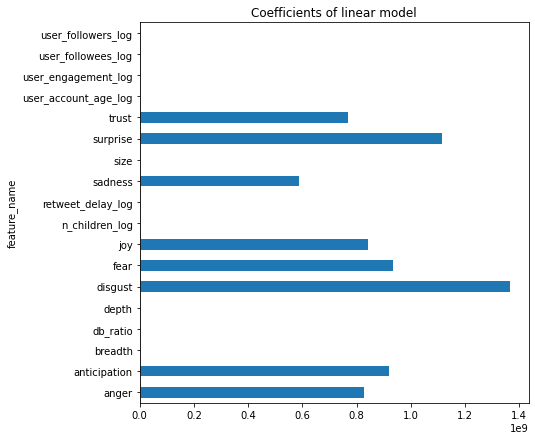

In [11]:
#coefficients = coefficients.pivot(index='feature_name', columns='crop', values='coef')
coefficients['24_hour'].plot(kind='barh', figsize=(9, 7))
plt.title('Coefficients of linear model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
#plt.savefig('coeff.png')


In [17]:
# store results
results.to_csv('../results/experiment_2_base_models.csv', header=True, index=False)